# Práctica árboles de clasificación     
## Máster Data Science (Noviembre 2019)
### M.N Legasa (legasam@unican.es),  Santander Meteorology Group.

En la práctica de hoy vamos a profundizar un poco más sobre algunos de los conceptos que vimos en la sesión de teoría. En particular, veremos cómo se trabaja para encontrar la configuración óptima de un árbol de clasificación, para lo cual necesitamos tener presentes las nociones ya vistas sobre overfitting (sobreajuste) y cross-validación.  Utilizaremos los paquetes *tree*, *rpart* y *caret*.

En primer lugar, cargamos el dataset con el que vamos a trabajar, *Carseats* (incluído en el paquete *ISLR*).

In [1]:
library(ISLR)
dataset = Carseats
head(dataset)

Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
11.22,111,48,16,260,83,Good,65,10,Yes,Yes
10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4.15,141,64,3,340,128,Bad,38,13,Yes,No
10.81,124,113,13,501,72,Bad,78,16,No,Yes


In [2]:
summary(dataset)

     Sales          CompPrice       Income        Advertising    
 Min.   : 0.000   Min.   : 77   Min.   : 21.00   Min.   : 0.000  
 1st Qu.: 5.390   1st Qu.:115   1st Qu.: 42.75   1st Qu.: 0.000  
 Median : 7.490   Median :125   Median : 69.00   Median : 5.000  
 Mean   : 7.496   Mean   :125   Mean   : 68.66   Mean   : 6.635  
 3rd Qu.: 9.320   3rd Qu.:135   3rd Qu.: 91.00   3rd Qu.:12.000  
 Max.   :16.270   Max.   :175   Max.   :120.00   Max.   :29.000  
   Population        Price        ShelveLoc        Age          Education   
 Min.   : 10.0   Min.   : 24.0   Bad   : 96   Min.   :25.00   Min.   :10.0  
 1st Qu.:139.0   1st Qu.:100.0   Good  : 85   1st Qu.:39.75   1st Qu.:12.0  
 Median :272.0   Median :117.0   Medium:219   Median :54.50   Median :14.0  
 Mean   :264.8   Mean   :115.8                Mean   :53.32   Mean   :13.9  
 3rd Qu.:398.5   3rd Qu.:131.0                3rd Qu.:66.00   3rd Qu.:16.0  
 Max.   :509.0   Max.   :191.0                Max.   :80.00   Max.   :18.0  

 Tal y como hicimos ayer con la variable *Price* del dataset *cars*, convertiremos la variable continua *Sales* (cantidad de carritos vendidos, en miles de unidades) a categórica, que podrá tomar los valores *No* (valores menores o iguales a 8) y *Yes* (valores mayores que 8). Esta nueva variable categórica será nuestra variable objetivo a clasificar durante la práctica. Por conveniencia, la vamos a renombar como *high*.

In [3]:
# convertimos Sales a categórica
high = ifelse(dataset$Sales <= 8, "No", "Yes")
dataset$Sales = as.factor(high)
names(dataset)[1] = "high"
head(dataset)

high,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Yes,138,73,11,276,120,Bad,42,17,Yes,Yes
Yes,111,48,16,260,83,Good,65,10,Yes,Yes
Yes,113,35,10,269,80,Medium,59,12,Yes,Yes
No,117,100,4,466,97,Medium,55,14,Yes,Yes
No,141,64,3,340,128,Bad,38,13,Yes,No
Yes,124,113,13,501,72,Bad,78,16,No,Yes


**Ejercicio:** Para el siguiente árbol, explica por qué ha cogido como primer nodo `ShelveLoc` y no, por ejemplo, `US`. Ayúdate de la diferencia de entropía (Information Gain).

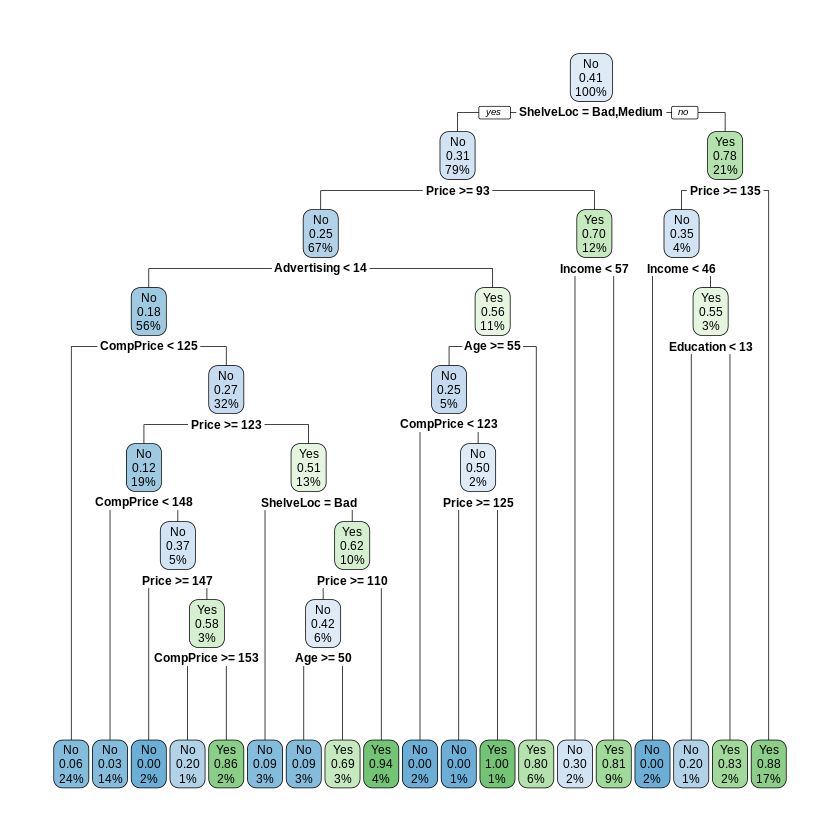

In [4]:
library(rpart)
library(rpart.plot)
t <- rpart(formula = high ~ ., data = dataset, method = "class", minsplit = 5, minbucket = 5, 
           parms = list(split = "information"))
rpart.plot(t)

Aunque en la práctica la implementación del algoritmo es más compleja, como ya comentamos en clase en este ejercicio se trata de comprobar el Information Gain (reducción de entropía) de dividir utilizando un predictor u otro:

In [5]:
P_h <- mean(dataset$high == "Yes") # P("High = Yes") Notar como coincide el resultado en el árbol

# Para mayor simplicidad, lo hacemos siguiendo la nomenclatura de la teoria: 

# Entropia inicial del dataset
HX <- -P_h*log(P_h) - (1-P_h)*log(1-P_h) 
       # Formula de la entropia, como hay dos estados, P("High = No")=1-P("High = Yes") 

# Podemos crear esta pequena funcion auxiliar para ahorrar tiempo:
calcularEntropia <-
  function(predictor, predictor.corte) {
    PXY <- c(
        p_x1.y1 = mean(dataset[[predictor]] == predictor.corte & dataset$high == "Yes"),
        p_x1.y2 = mean(dataset[[predictor]] != predictor.corte & dataset$high == "Yes"),
        p_x2.y1 = mean(dataset[[predictor]] == predictor.corte & dataset$high == "No"),
        p_x2.y2 = mean(dataset[[predictor]] != predictor.corte & dataset$high == "No")
    )

    PX_dado_Y <- c(
        P_x1_dado_y1 = mean(dataset[dataset[[predictor]] == predictor.corte, "high"] == "Yes"),
        P_x1_dado_y2 = mean(dataset[dataset[[predictor]] != predictor.corte, "high"] == "Yes")
    )
    PX_dado_Y <- c(PX_dado_Y,
                   P_x2_dado_y1 = 1 - PX_dado_Y[1],
                   P_x2_dado_y2 = 1 - PX_dado_Y[2]
                  )

    H_X_dado_Y <- -sum(PXY*log(PX_dado_Y))
    return(H_X_dado_Y)
    }

c(IG_ShelveLoc = HX - calcularEntropia(predictor = "ShelveLoc",
                 predictor.corte = "Good"),
  IG_US = HX - calcularEntropia(predictor = "US",
                 predictor.corte = "Yes")
  )

IG_ShelveLoc        IG_US 
  0.07570943   0.01711700

Vemos que dividiendo por ShelveLoc la entropía es menor y la ganancia de información mayor.

A continuación, vamos a definir una nueva función (nómbrala *acc.class*) que calcule el índice de validación que utilizaremos a lo largo de toda la práctica; el ratio de aciertos o *accuracy*, que ya explicamos el día anterior:

In [6]:
## evaluation function
acc.class = function(x, y) {
  stopifnot(length(x) == length(y))
  return(sum(diag(table(x, y))) / length(x))
}

Y dividimos (aleatoriamente) el dataset total en dos subconjuntos independientes de train y test (mitad del dataset cada uno).

In [7]:
## train and test independientes
n = nrow(dataset)
set.seed(2)
indtrain = sample(1:n, 0.5*n)
indtest = setdiff(1:n, indtrain)
dataset.train = dataset[indtrain, ]
dataset.test = dataset[indtest, ]

El primer objetivo de la práctica es obtener, manualmente, la configuración óptima del árbol (aquella que minimiza el error de test, para no caer en sobreajuste). Para ello debemos ver cómo evoluciona el error de clasificación en el train y en el test, en función de la *complejidad del árbol*.

**Ejercicio:** Aprende primero el árbol con el dataset de train (función *tree*). A continuación, tendrás que ir podando este árbol (escoje valores para el número de hojas entre 3 y 15) y calcular su accuracy para clasificar, tanto sobre el dataset de train como sobre el de test. Dibuja ambos errores en función del número de hojas del árbol e interpreta los resultados. ¿Cuál sería la configuración óptima del árbol?  
**Nota**: Utiliza la función *prune.tree* (argumento *best*).

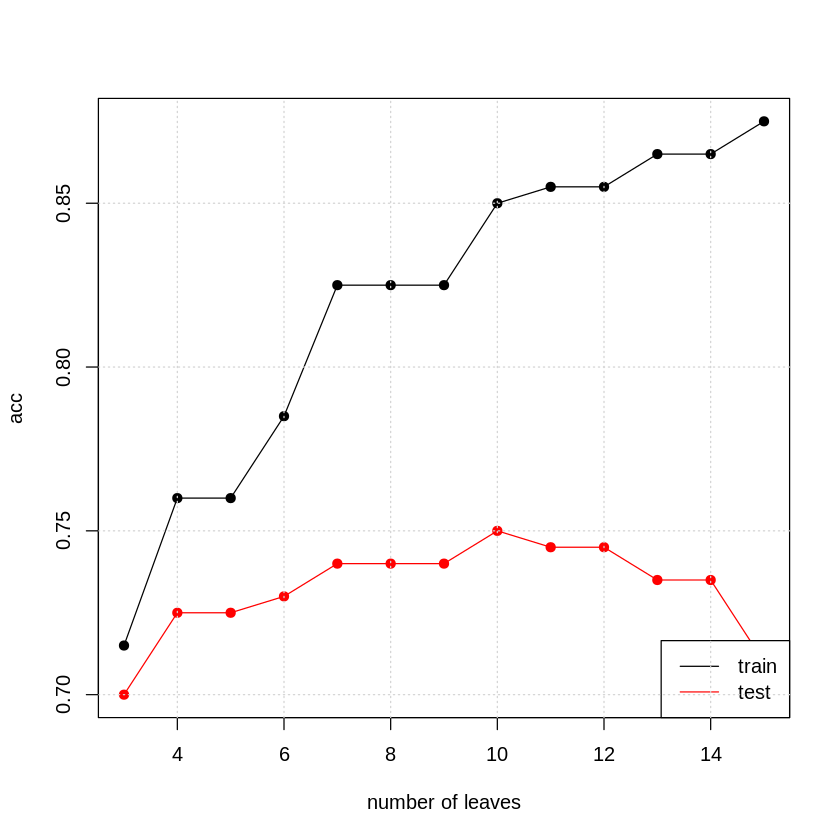

In [8]:
## pruning the tree to find the optimal configuration 
# learning the tree
library(tree)
t = tree(high ~ ., dataset.train)

acc.train = c()
acc.test = c()
nleaf = 3:15
for (n in nleaf) {
  # pruning the learnt tree (based on parameter "best")
  t.pruned = prune.tree(t, best = n)
  
  # performance on training data
  pred.train = predict(t.pruned, dataset.train, type = "class")
  acc.train[nleaf == n] = acc.class(pred.train, dataset.train$high)
  
  # performance on test data
  pred.test = predict(t.pruned, dataset.test, type = "class")
  acc.test[nleaf == n]= acc.class(pred.test, dataset.test$high)
}
matplot(nleaf, t(rbind(acc.train, acc.test)), 
        type = "o", pch = 19, lty = 1, col = c("black", "red"),
        xlab = "number of leaves", ylab = "acc")
legend("bottomright", c("train", "test"), lty = 1, col = c("black", "red"))
grid()

La función *cv.tree* permite hacer lo mismo de forma más rápida. 

**Ejercicio:** Lee la documentación de la misma e intenta llegar a una conclusión similar por tí mism@.
**Idea:** Busca en el objeto de salida que te devuelva la función *cv.tree* y dibuja el factor de desviación (medida que da idea del error de clasificación) en función del tamaño del árbol.

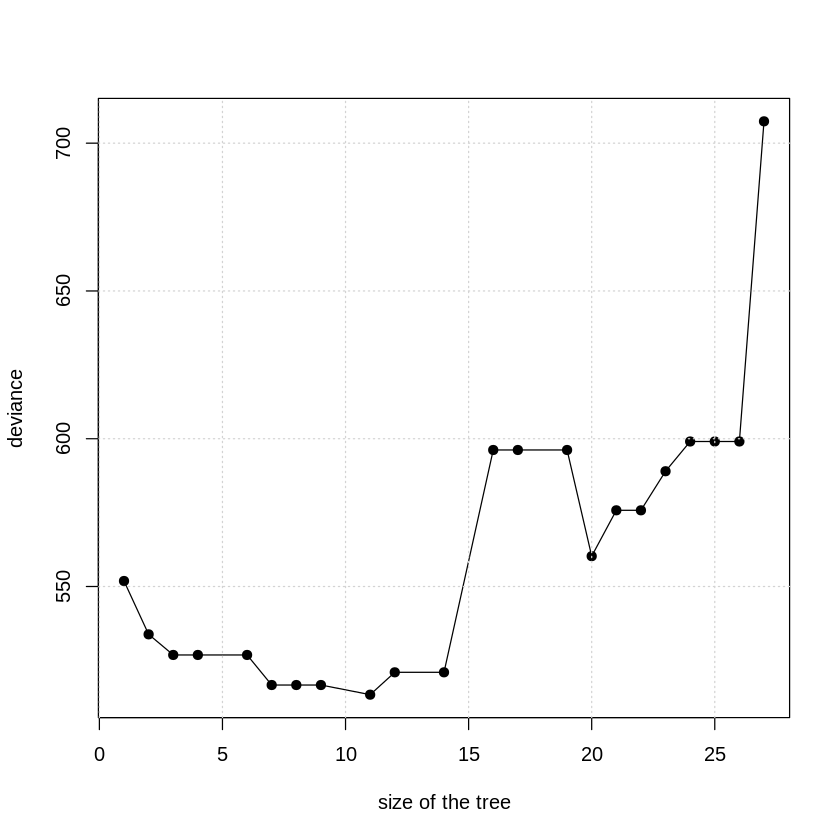

In [9]:
set.seed(2)
library(tree)
t = tree(high ~ ., dataset)
# hold-out cross-validation
t.cv = cv.tree(t, K = 2)  
# deviance ~ entropy ~ error
plot(t.cv$size, t.cv$dev, type = "o", pch = 19, 
     xlab = "size of the tree", ylab = "deviance")
grid()

Una vez hemos encontrado la configuración óptima (número de hojas) de nuestro árbol, evalúa el accuracy del árbol completo y el del óptimo, tanto en train como en test. ¿Qué conclusión obtienes?

In [10]:
## performance in train
set.seed(4)
# total tree
t = tree(high ~ ., dataset.train)
pred.train = predict(t, dataset.train, type = "class")
# optimum tree
t.opt = prune.tree(t, best = 10)
pred.train.opt = predict(t.opt, dataset.train, type = "class")

acc.class(pred.train, dataset.train$high)
acc.class(pred.train.opt, dataset.train$high)

[1] 0.89

[1] 0.85

In [11]:
# performance in test
set.seed(7)
pred.test = predict(t, dataset.test, type = "class")
pred.test.opt = predict(t.opt, dataset.test, type = "class")
acc.class(pred.test, dataset.test$high)
acc.class(pred.test.opt, dataset.test$high)

[1] 0.715

[1] 0.75

¿Cuántas hojas tiene el árbol total? Dibuja ambos árboles para ver la diferencia en complejidad. 


Classification tree:
tree(formula = high ~ ., data = dataset.train)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "Age"         "Advertising"
[6] "CompPrice"   "Population" 
Number of terminal nodes:  19 
Residual mean deviance:  0.4282 = 77.51 / 181 
Misclassification error rate: 0.105 = 21 / 200 


Classification tree:
snip.tree(tree = t, nodes = c(39L, 6L, 307L, 8L))
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Advertising" "CompPrice"   "Age"        
Number of terminal nodes:  10 
Residual mean deviance:  0.7114 = 135.2 / 190 
Misclassification error rate: 0.15 = 30 / 200 

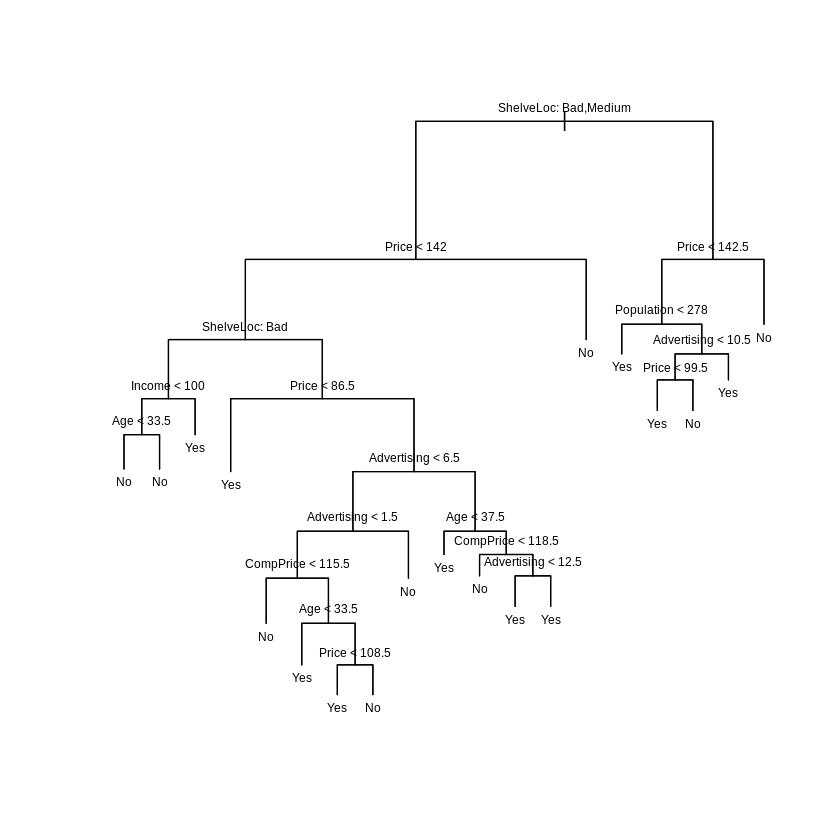

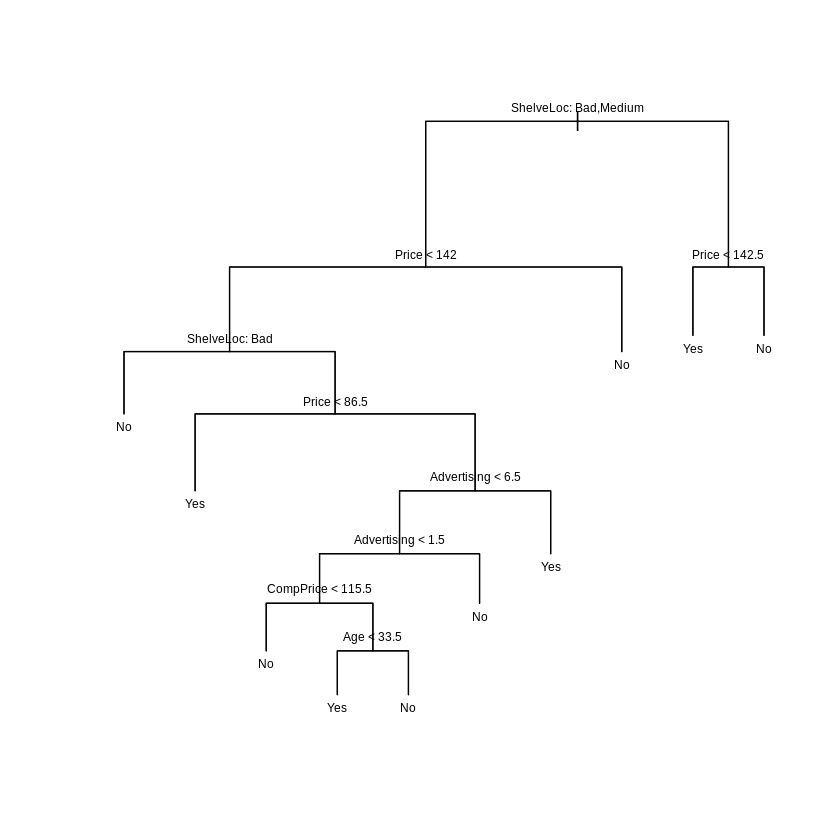

In [12]:
# hojas/niveles tiene cada arbol?
summary(t)
summary(t.opt)
plot(t); text(t, pretty = F, cex = 0.6)
plot(t.opt); text(t.opt, pretty = F, cex = 0.6)

Hasta ahora, hemos obtenido la configuración ótpima del árbol en función del número de hojas del mismo. La idea en este caso es fijarnos en otro parámetro, la profundidad del árbol (ambos conceptos están relacionados). Para ello, aprende un conjunto árboles de diferente profundidad (de 1 a 10 niveles) en el train y evalúa su accuracy para clasificar en el test. Dibuja dicho accuracy en función de la profundidad del árbol. ¿Cuál sería la configuración óptima en este caso? Compara el accuracy obtenido para esta configuración con el que teníamos del ejercicio anterior.  
**Nota:** Usa la función *rpart*.

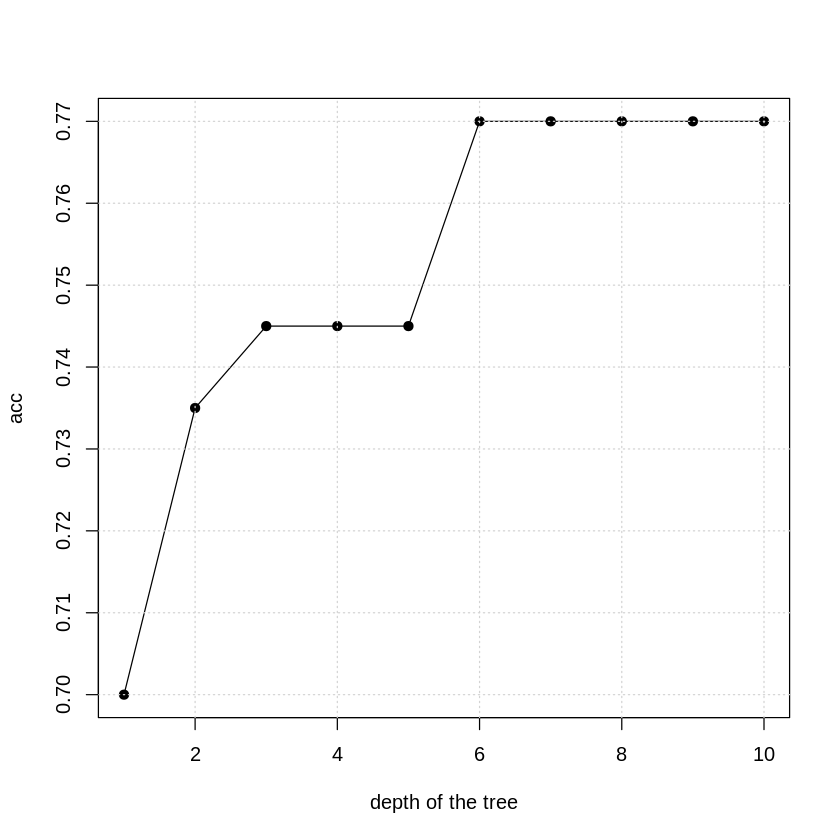

In [13]:
library(rpart)
md = 1:10
acc.test = c()
for (i in md) {
  t.train = rpart(high ~ ., dataset.train, maxdepth = i)
  pred.test = predict(t.train, dataset.test, type = "class")
  acc.test[i] = acc.class(pred.test, dataset.test$high)
}
plot(md, acc.test, type = "o", pch = 19, xlab = "depth of the tree", ylab = "acc")
grid()

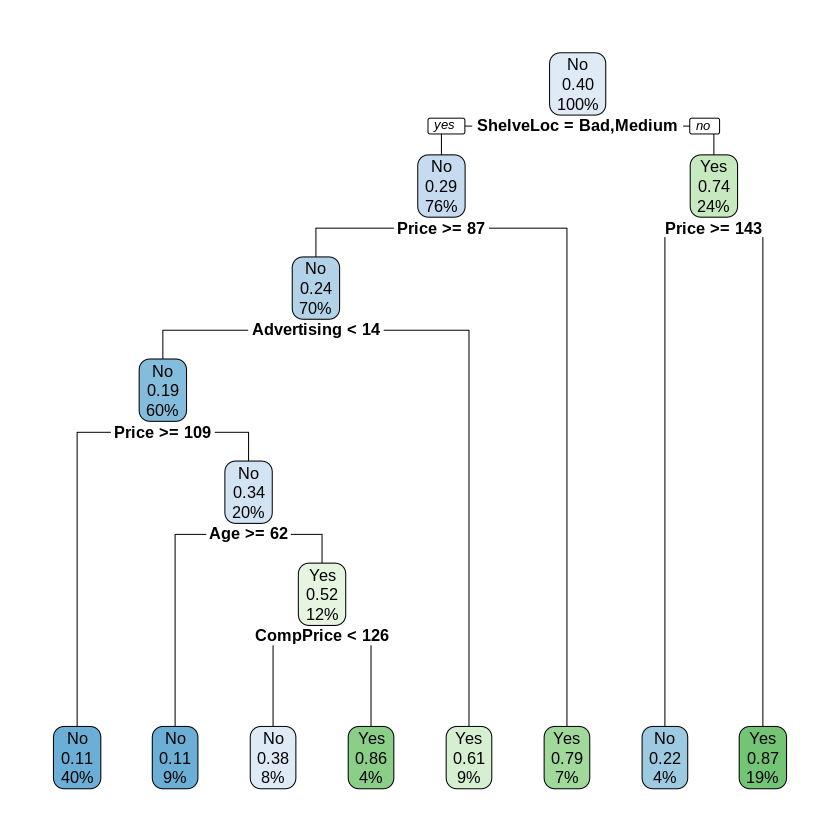

In [14]:
rpart.plot(t.train)

Como vimos durante la sesión de teoría, el paquete *caret* pemite evaluar de forma sencilla la idoneidad de un gran número de configuraciones del árbol considerando distintos tipos de cross-validación. En este ejercicio, vamos a pasar del hold-out que hemos utilizado hasta ahora, a una cross-validación con 5 folds (función *trainControl*).  
**Ejercicio:** Utilizando la función *train*, calcula el accuracy que se obtiene para 5 árboles de distinta profundidad (valores escogidos internamente por *caret*) bajo un esquema de cross-validación con 5 folds. Dibujar los resultados.  
**Preguntas:** ¿Cuál es la configuración óptima del árbol en este caso? ¿Los resultados son diferentes a lo que esperabas obtener? ¿A qué puede deberse?  
**Nota:** La siguiente página ofrece una documentación muy buena de *caret*: https://topepo.github.io/caret

Loading required package: lattice
Loading required package: ggplot2


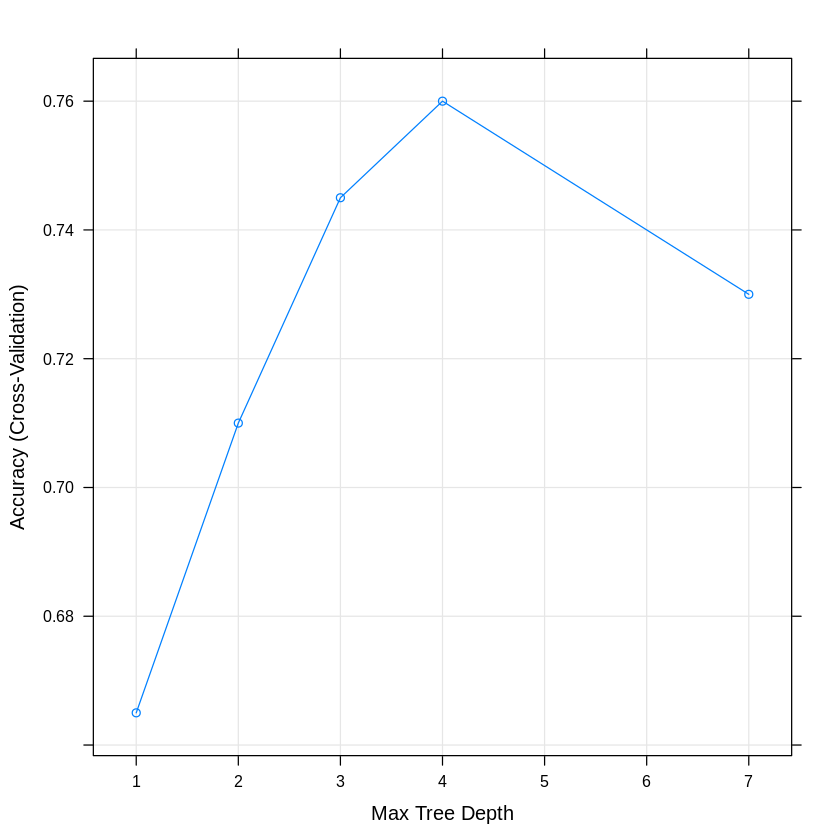

In [15]:
library(caret)
trctrl = trainControl(method = "cv", number = 5)  # cross-validation with 5 folds
## caret automatically tries different values of the method parameter: internal selection
t = train(high ~ ., data = dataset.train,
          method = "rpart2",
          trControl = trctrl,
          tuneLength = 5)
plot(t) 

En lugar de dejar que *caret* seleccione internamente los valores del parámetro (en este caso *maxdepth*) a probar, podemos especificárselos nosotr@s. Para ello hay que definir el *grid* que va a considerar *caret* (argumento *tuneGrid*).

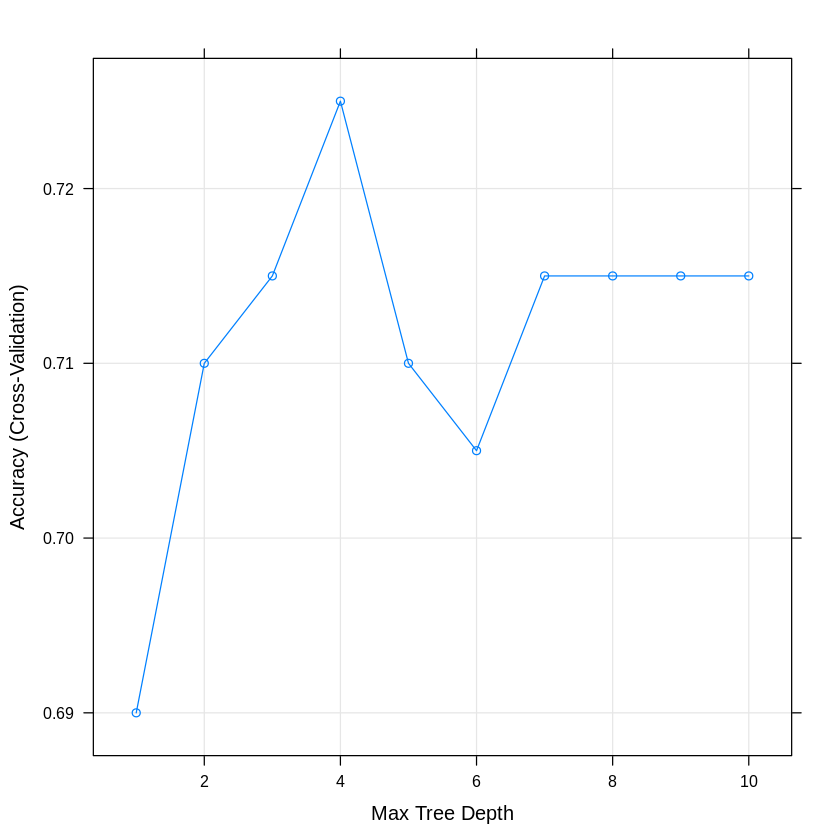

In [16]:
## caret automatically tries different values of the method parameter: user-defined selection
trctrl = trainControl(method = "cv", number = 5)
md = 1:10  # maximum depth allowed for the tree
t = train(high ~ ., data = dataset.train,
            method = "rpart2",
            trControl = trctrl,
            tuneGrid = expand.grid(maxdepth = md))
plot(t)  

**Preguntas:** Podemos ver que los resultados han cambiado, ¿verdad? ¿Por qué? ¿Qué pasa si ejecutas varias veces el bloque de código anterior?

**Ejercicio:** Para comprobar el efecto que tiene en nuestros resulados la elección de los subconjuntos de train y test, repite el ejercicio anterior 20 veces, salvando en cada iteración la profundidad del árbol óptimo (prueba valores entre 1 y 10). 
**Idea:** Puedes usar un bucle *while*.
**Pregunta:** ¿Cómo dirías que es el efecto de la partición train/test en el proceso de optimización del árbol?

[1] "... realization 1 ..."
[1] "... realization 2 ..."
[1] "... realization 3 ..."
[1] "... realization 4 ..."
[1] "... realization 5 ..."
[1] "... realization 6 ..."
[1] "... realization 7 ..."
[1] "... realization 8 ..."
[1] "... realization 9 ..."
[1] "... realization 10 ..."
[1] "... realization 11 ..."
[1] "... realization 12 ..."
[1] "... realization 13 ..."
[1] "... realization 14 ..."
[1] "... realization 15 ..."
[1] "... realization 16 ..."
[1] "... realization 17 ..."
[1] "... realization 18 ..."
[1] "... realization 19 ..."
[1] "... realization 20 ..."


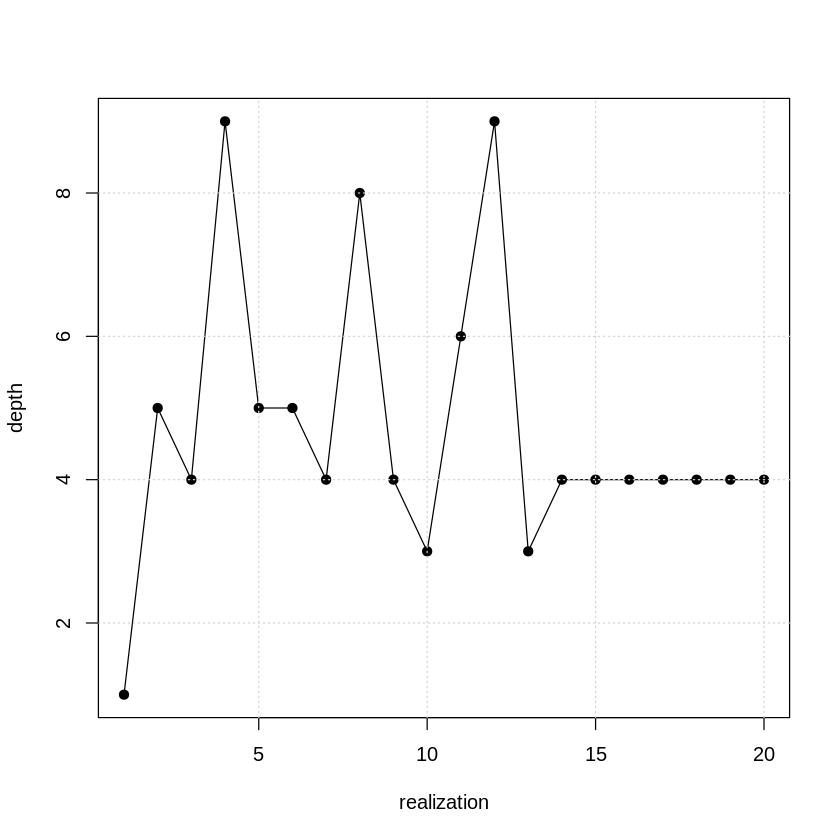

In [17]:
## effect of train/test partition on optimum depth
trctrl = trainControl(method = "cv", number = 5)
md = 1:10
depth = c()

i = 1
while (i <= 20) {
print(sprintf("... realization %d ...", i))
t = train(high ~ ., data = dataset.train,
          method = "rpart2",
          trControl = trctrl,
          tuneGrid = expand.grid(maxdepth = md))
depth[i] = t$bestTune$maxdepth
i = i+1
}

plot(1:20, depth, type = "o", pch = 19, xlab = "realization") 
grid()

**Ejercicio:** Una vez hemos definido una profundidad óptima para nuestro árbol, comprueba ahora cuál sería el efecto de la partición train/test sobre el accuracy en el test.  
**Idea:** Reutiliza el código anterior. Entre muchas otras cosas, la función *train* devuelve lo que estás buscando. Da una estimación (valor promedio +/- margen de incertidumbre) del accuracy en el test.

[1] "... realization 1 ..."
[1] "... realization 2 ..."
[1] "... realization 3 ..."
[1] "... realization 4 ..."
[1] "... realization 5 ..."
[1] "... realization 6 ..."
[1] "... realization 7 ..."
[1] "... realization 8 ..."
[1] "... realization 9 ..."
[1] "... realization 10 ..."
[1] "... realization 11 ..."
[1] "... realization 12 ..."
[1] "... realization 13 ..."
[1] "... realization 14 ..."
[1] "... realization 15 ..."
[1] "... realization 16 ..."
[1] "... realization 17 ..."
[1] "... realization 18 ..."
[1] "... realization 19 ..."
[1] "... realization 20 ..."


[1] 0.73325000 0.01830121

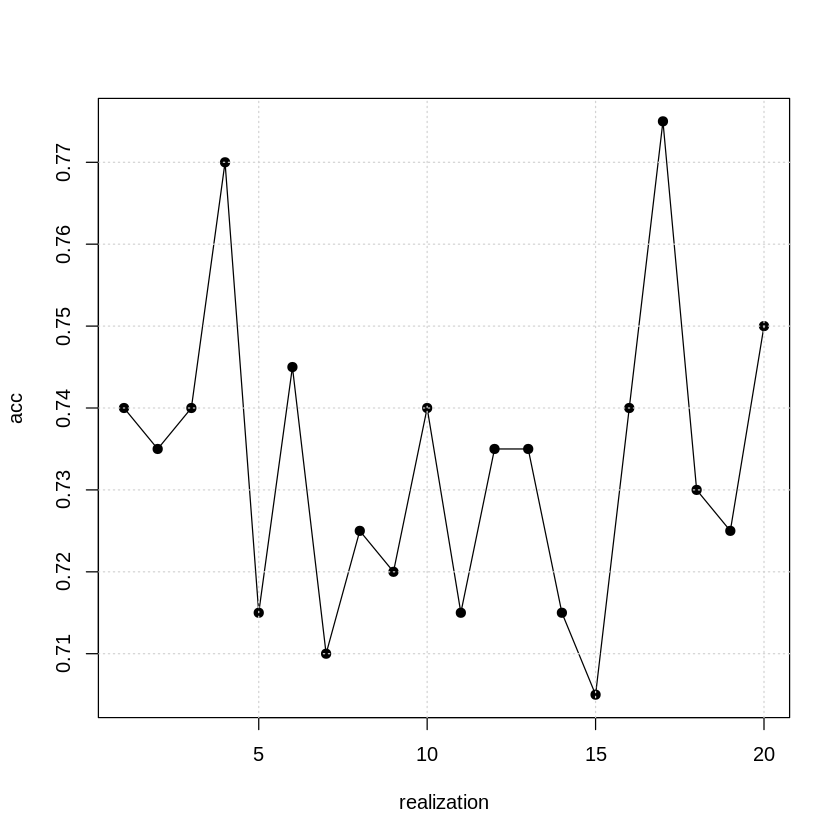

In [18]:
## effect on accuracy of train/test partition
trctrl = trainControl(method = "cv", number = 5)
acc = c()

i = 1
while (i <= 20) {
  print(sprintf("... realization %d ...", i))    
  t = train(high ~ ., data = dataset.train,
            method = "rpart2",
            trControl = trctrl,
            tuneGrid = expand.grid(maxdepth = 5))
  acc[i] = t$results$Accuracy
  i = i+1
}

plot(1:20, acc, type = "o", pch = 19, xlab = "realization")  
grid()

c(mean(acc), sd(acc))

El ejercicio anterior puede hacerse de forma mucho más sencilla simplemente con cambiar el modo en el que definimos la cross-validación.
**Ejercicio:** Revisa la documentación de la función *trainControl* y replica el ejercicio anterior.

In [19]:
## previous block with caret
trctrl = trainControl(method = "repeatedcv", number = 5, repeats = 20)
## caret automatically tries different values of the method parameter 
t = train(high ~ ., data = dataset.train,
          method = "rpart2",
          trControl = trctrl,
          tuneGrid = expand.grid(maxdepth = 5))
c(t$results$Accuracy, t$results$AccuracySD)

[1] 0.72775000 0.07570335

Además de la partición train/test, el número de folds considerados también puede tener un efecto sobre la configuración óptima del árbol. 
**Ejercicio:** Para finalizar la práctica de hoy, comprueba cómo varía la profundidad óptima del árbol (posibles valores entre 1 y 10) al cambiar el número de folds (desde 5 hasta 30).

[1] "... trying with 5 folds ..."
[1] "... trying with 6 folds ..."
[1] "... trying with 7 folds ..."
[1] "... trying with 8 folds ..."
[1] "... trying with 9 folds ..."
[1] "... trying with 10 folds ..."
[1] "... trying with 11 folds ..."
[1] "... trying with 12 folds ..."
[1] "... trying with 13 folds ..."
[1] "... trying with 14 folds ..."
[1] "... trying with 15 folds ..."
[1] "... trying with 16 folds ..."
[1] "... trying with 17 folds ..."
[1] "... trying with 18 folds ..."
[1] "... trying with 19 folds ..."
[1] "... trying with 20 folds ..."
[1] "... trying with 21 folds ..."
[1] "... trying with 22 folds ..."
[1] "... trying with 23 folds ..."
[1] "... trying with 24 folds ..."
[1] "... trying with 25 folds ..."
[1] "... trying with 26 folds ..."
[1] "... trying with 27 folds ..."
[1] "... trying with 28 folds ..."
[1] "... trying with 29 folds ..."
[1] "... trying with 30 folds ..."


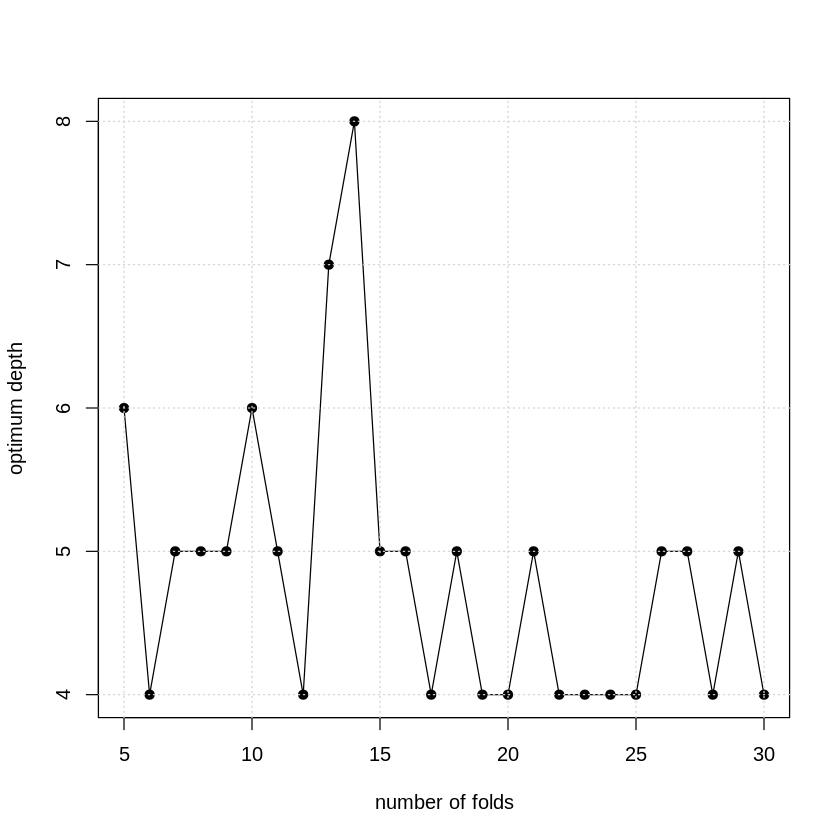

In [20]:
## effect of number of folds
k = 5:30

depth = c()
for (nf in k) {
  print(sprintf("... trying with %d folds ...", nf))
  trctrl = trainControl(method = "cv", number = nf)
  t = train(high ~ ., data = dataset.train,
            method = "rpart2",
            trControl = trctrl,
            tuneGrid = expand.grid(maxdepth = 1:10))
  depth[k == nf] = t$bestTune$maxdepth  
}
plot(k, depth, type = "o", pch = 19,
     xlab = "number of folds", ylab = "optimum depth") 
grid()